# Exploratory Data Analysis (Email Campaigns)

We will be exploring the Email Campaign data which is currently broken into 3 files namely 

<ul>
    <li>
        <b>Sent:</b> Contains the Emails Sent
    </li>
    <li>
        <b>Customers:</b> Contains the demographic details of customers
    </li>
    <li>
        <b>Received:</b> Contains the information of which emails were opened
    </li>
</ul>



In [1]:
!pip install pandas 
!pip install numpy 
!pip install scikit-learn 

You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [2]:
# Set up the notebook to import modules from relative paths
import os, sys

#'/home/user/example/parent/child'
current_path = os.path.abspath('.')

#'/home/user/example/parent'
parent_path = os.path.dirname(current_path)

sys.path.append(parent_path)

In [3]:
import pandas as pd
import numpy as np

from IPython.display import display, HTML

# Display Properties
from IPython.display import display, HTML
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 2)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [4]:
df_user = pd.read_csv('/workspace/shared-data/email-campaign/userbase.csv')
df_user.head()

,Customer_ID,Gender,Type,Email_Address,Age,Tenure
0,1,M,C,Mph@msn.com,38,12
1,2,F,B,SophcYN7381qMe8lRqK@aol.com,37,23
2,3,F,C,xE@msn.com,32,15
3,4,M,C,WduR0o0@comcast.net,31,24
4,5,M,C,walHI9cmWJIBKvy0@aol.com,35,13


In [5]:
df_sent = pd.read_csv('/workspace/shared-data/email-campaign/sent_emails.csv')
df_sent.head()

,Sent_Date,Customer_ID,SubjectLine_ID
0,2016-01-28,1413,2
1,2016-03-02,83889,2
2,2016-03-09,457832,3
3,2016-01-20,127772,1
4,2016-02-03,192123,3


In [6]:
df_received = pd.read_csv('/workspace/shared-data/email-campaign/responded.csv')
df_received.head()

,Responded_Date,Customer_ID,SubjectLine_ID
0,2016-01-25,217102,3
1,2016-03-26,366875,2
2,2016-03-17,201561,2
3,2016-01-11,395345,3
4,2016-01-11,427539,3


In [7]:
df_received_copy = df_received.copy(deep=True)
df_received_copy = df_received_copy.drop_duplicates(subset=['SubjectLine_ID','Customer_ID']) 

In [8]:
print(f"We have {len(df_sent)} sent emails across {len(df_user)} customers with overall {len(df_received)} receipts and {len(df_received_copy)} unique receipts.")

We have 2476354 sent emails across 500000 customers with overall 378208 receipts and 334100 unique receipts.


### Multiple Responses and Merging

Above tells us that there are some sent emails that are opened / responded to multiple times and for the purpose of our analysis where we are tracking whether an email is opened or not. So following processing techniques will help us get a dataset that we can do further modelling on 

<ul>
    <li>
        <b>Removing Duplicates:</b> Remove duplicate Emails Responded using <b>SubjectLine_ID</b> and <b>Customer_ID</b> as the combination keys 
    </li>
    <li>
        <b>Merging:</b> Merging using Left Outer Join between Sent, Customers and Received will give us a target dataset that we can work with for further modelling
    </li>
</ul>

In [9]:
df_merge = pd.merge(df_sent, df_user, how='left', on=['Customer_ID'])
df_merge.head()

,Sent_Date,Customer_ID,SubjectLine_ID,Gender,Type,Email_Address,Age,Tenure
0,2016-01-28,1413,2,M,B,Jaj2NuUJneD@gmail.com,44,12
1,2016-03-02,83889,2,M,C,Y1Se1qBYrUe@hotmail.com,29,23
2,2016-03-09,457832,3,M,C,vAF@gmail.com,26,14
3,2016-01-20,127772,1,M,C,QAWqTT@gmail.com,26,15
4,2016-02-03,192123,3,M,C,Qtgy0C@msn.com,33,9


In [10]:
df_merge_recd = pd.merge(df_merge, df_received_copy, how='left', on=['SubjectLine_ID','Customer_ID'])
df_merge_recd.head()

,Sent_Date,Customer_ID,SubjectLine_ID,Gender,Type,Email_Address,Age,Tenure,Responded_Date
0,2016-01-28,1413,2,M,B,Jaj2NuUJneD@gmail.com,44,12,2016-01-31
1,2016-03-02,83889,2,M,C,Y1Se1qBYrUe@hotmail.com,29,23,NaN
2,2016-03-09,457832,3,M,C,vAF@gmail.com,26,14,NaN
3,2016-01-20,127772,1,M,C,QAWqTT@gmail.com,26,15,NaN
4,2016-02-03,192123,3,M,C,Qtgy0C@msn.com,33,9,2016-02-04


In [11]:
print(f"We have {len(df_merge)} sent emails joined with Customers and then {len(df_merge_recd)} target indicating we have preserved the total sent for this analysis.")

We have 2476354 sent emails joined with Customers and then 2476354 target indicating we have preserved the total sent for this analysis.


### Preprocessing

We will now perform some analysis and then transformations to make this dataset into what would make sense 

<ul>
    <li>
        <b>Dropping columns:</b> From this dataset, we can drop columns like <b>Customer_ID</b> (because for a prediction we are interested in the generality which we can get from the demographic attributes vs a specific customer) and <b>Responded_Date</b> (because for a prediction of whether the person responded we are more interested on when it was sent since if it was responded to then the sent_date has the needed info for us to understand general patterns). 
    </li>
    <li>
        <b>Unique Values:</b> Understanding the Unique values will help us see if we need to perform any transformations to make the model more general without impacting the model performance. We see below that Gender and Type are sparse (2 values) and so we don't need to make any transformations. For Age and Tenure we can make some transformations by putting them in bins. We also have 6 unique email domains that might be helpful to see if certain domains have different spam filter settings that affects the response rate
    </li>
    <li>
        <b>Transformations:</b> We create some derived attributes namely <b>Age_Group</b>, <b>Tenure_Group</b>, <b>Domain</b> and <b>Weekday</b> and drop the original columns. We will also use create a <b>Response_Received</b> to indicate if response was received
    </li>
</ul>

In [12]:
domain_list = df_merge_recd['Email_Address'].str.split('@').str[1]
df_merge_recd['Email_Domain'] = domain_list
df_merge_recd.head()

,Sent_Date,Customer_ID,SubjectLine_ID,Gender,Type,Email_Address,Age,Tenure,Responded_Date,Email_Domain
0,2016-01-28,1413,2,M,B,Jaj2NuUJneD@gmail.com,44,12,2016-01-31,gmail.com
1,2016-03-02,83889,2,M,C,Y1Se1qBYrUe@hotmail.com,29,23,NaN,hotmail.com
2,2016-03-09,457832,3,M,C,vAF@gmail.com,26,14,NaN,gmail.com
3,2016-01-20,127772,1,M,C,QAWqTT@gmail.com,26,15,NaN,gmail.com
4,2016-02-03,192123,3,M,C,Qtgy0C@msn.com,33,9,2016-02-04,msn.com


In [13]:
# Get the total records
total_records = len(df_merge_recd)

# Get unique values for Gender
unique_gender = df_merge_recd['Gender'].nunique() 

# Get unique values for Type
unique_type = df_merge_recd['Type'].nunique() 

# Unique values for the age
unique_age = df_merge_recd['Age'].nunique() 

# Get Unique Tenure
unique_tenure = df_merge_recd['Tenure'].nunique()

# Get Unique Domains
unique_domains = df_merge_recd['Email_Domain'].nunique()

unique_stats = np.column_stack((total_records, unique_gender, unique_type, unique_age, 
                                unique_tenure, unique_domains))
unique_stats_df = pd.DataFrame(unique_stats, columns = ['Total','Unique Gender',
                                                        'Unique Types','Unique Age', 
                                                        'Unique Tenure','Unique Domains'])
display(HTML(unique_stats_df.to_html()))

,Total,Unique Gender,Unique Types,Unique Age,Unique Tenure,Unique Domains
0,2476354,2,2,46,38,6


array([[<AxesSubplot:title={'center':'Age'}>]], dtype=object)

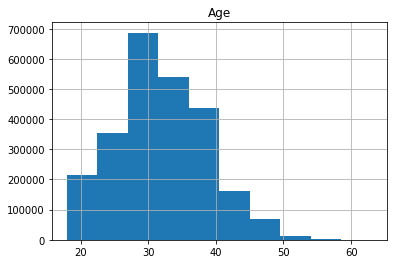

In [14]:
df_merge_recd.hist(column='Age')

array([[<AxesSubplot:title={'center':'Tenure'}>]], dtype=object)

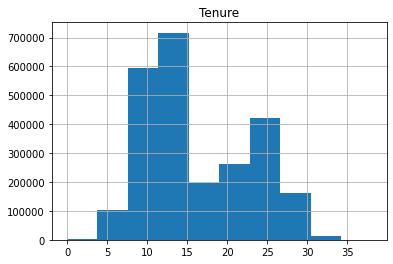

In [15]:
df_merge_recd.hist(column='Tenure')

In [16]:
from sklearn import preprocessing 

# This function converts given age to age group
def age_group(age): 
    if (age < 20):
        return 0
    elif (age >= 20 and age <25):
        return 1
    elif (age >= 25 and age <35):
        return 2
    elif (age >= 35 and age <45):
        return 3  
    else:
        return 4

# This function converts given tenure to Tenure Group 
def tenure_group(tenure): 
    if (tenure < 5):
        return 0
    elif (tenure >= 5 and tenure <10):
        return 1
    elif (tenure >= 10 and tenure <15):
        return 2
    elif (tenure >= 15 and tenure <20):
        return 3  
    elif (tenure >= 20 and tenure <25):
        return 4  
    elif (tenure >= 25 and tenure <30):
        return 5 
    else:
        return 6
    
def response_received(responded_date): 
    if responded_date == 'NoResponseReceived':
        return 0
    else:
        return 1

# Compute age group from Age
df_merge_recd['Age_Group'] = df_merge_recd['Age'].apply(age_group) 

# Compute age group from Age
df_merge_recd['Tenure_Group'] = df_merge_recd['Tenure'].apply(tenure_group) 

# Compute Response Received
df_merge_recd[['Responded_Date']] = df_merge_recd[['Responded_Date']].fillna('NoResponseReceived')
df_merge_recd['Response_Received'] = df_merge_recd['Responded_Date'].apply(response_received) 

# Get week day from date
df_merge_recd["sent_dt"] = pd.to_datetime(df_merge_recd['Sent_Date'], format='%Y-%m-%d', errors='coerce')
df_merge_recd["Sent_Day"] = df_merge_recd['sent_dt'].dt.weekday

# Label Encode Gender, Type and Domain
gender_encoder = preprocessing.LabelEncoder() 
type_encoder = preprocessing.LabelEncoder() 
domain_encoder = preprocessing.LabelEncoder() 

df_merge_recd['Gender']= gender_encoder.fit_transform(df_merge_recd['Gender']) 
df_merge_recd['Type']= type_encoder.fit_transform(df_merge_recd['Type']) 
df_merge_recd['Email_Domain']= domain_encoder.fit_transform(df_merge_recd['Email_Domain']) 

df_merge_recd.head()

,Sent_Date,Customer_ID,SubjectLine_ID,Gender,Type,Email_Address,Age,Tenure,Responded_Date,Email_Domain,Age_Group,Tenure_Group,Response_Received,sent_dt,Sent_Day
0,2016-01-28,1413,2,1,0,Jaj2NuUJneD@gmail.com,44,12,2016-01-31,2,3,2,1,2016-01-28,3
1,2016-03-02,83889,2,1,1,Y1Se1qBYrUe@hotmail.com,29,23,NoResponseReceived,3,2,4,0,2016-03-02,2
2,2016-03-09,457832,3,1,1,vAF@gmail.com,26,14,NoResponseReceived,2,2,2,0,2016-03-09,2
3,2016-01-20,127772,1,1,1,QAWqTT@gmail.com,26,15,NoResponseReceived,2,2,3,0,2016-01-20,2
4,2016-02-03,192123,3,1,1,Qtgy0C@msn.com,33,9,2016-02-04,4,2,1,1,2016-02-03,2


In [17]:
# Drop the above columns
cols_to_drop = ['Sent_Date','Customer_ID','Email_Address','Age','Tenure','Responded_Date','sent_dt']
df = df_merge_recd.drop(columns=cols_to_drop,errors='ignore')
df.head()

,SubjectLine_ID,Gender,Type,Email_Domain,Age_Group,Tenure_Group,Response_Received,Sent_Day
0,2,1,0,2,3,2,1,3
1,2,1,1,3,2,4,0,2
2,3,1,1,2,2,2,0,2
3,1,1,1,2,2,3,0,2
4,3,1,1,4,2,1,1,2


Write the Email Campaign Data after transformation to local directory for loading as needed and then proceed to look at the total unique set of values and this will give us the overall state space

In [ ]:
df.to_csv('email_campaign_data.csv')

# Get the total records
total_records = len(df_merge_recd)

# Get unique values for Gender
unique_gender = df_merge_recd['Gender'].nunique() 

# Get unique values for Type
unique_type = df_merge_recd['Type'].nunique() 

# Unique values for the age
unique_age = df_merge_recd['Age_Group'].nunique() 

# Get Unique Tenure
unique_tenure = df_merge_recd['Tenure_Group'].nunique()

# Get Unique Domains
unique_domains = df_merge_recd['Email_Domain'].nunique()

# Get Unique Response Received
unique_responses = df_merge_recd['Response_Received'].nunique()

# Get Unique Subject Line Ids 
unique_subjects = df_merge_recd['SubjectLine_ID'].nunique()

# Get Unique Days of the week
unique_weekday = df_merge_recd['Sent_Day'].nunique()

unique_stats = np.column_stack((unique_subjects, unique_weekday, unique_gender, unique_type, unique_age, 
                                unique_tenure, unique_domains, unique_responses))
unique_stats_df = pd.DataFrame(unique_stats, columns = ['Unique Subjects','Unique Days of Week',
                                                        'Unique Gender','Unique Types',
                                                        'Unique Age Group','Unique Tenure Group',
                                                        'Unique Domains',
                                                        'Unique Response Categories'])
display(HTML(unique_stats_df.to_html()))

We will now aggregate this to visualize the actions we can take. Overall the spread across these attributes is more or less uniform i.e. not major outliers at least appearing visually

In [ ]:
# Group response probability by days of week
dow_group_df = df_merge_recd[["Response_Received","Sent_Day"]].groupby(['Response_Received','Sent_Day'])
dow_agg_group_df = dow_group_df[['Sent_Day']].count()
dow_agg_group_df

In [ ]:
# Get unique values for Gender
unique_genders = np.sort(df_merge_recd['Gender'].unique())
print(unique_genders)

# Get unique values for Type
unique_types = np.sort(df_merge_recd['Type'].unique()) 
print(unique_types)

# Unique values for the age groups
unique_age_groups = np.sort(df_merge_recd['Age_Group'].unique()) 
print(unique_age_groups)

# Get Unique Tenure
unique_tenures = np.sort(df_merge_recd['Tenure_Group'].unique())
print(unique_tenures)

# Get Unique Domains
unique_domains = np.sort(df_merge_recd['Email_Domain'].unique())
print(unique_domains)

# Get Unique Response Received
unique_response_results = np.sort(df_merge_recd['Response_Received'].unique())
print(unique_response_results)

# Get Unique Subject Line Ids 
unique_subjects = np.sort(df_merge_recd['SubjectLine_ID'].unique())
print(unique_subjects)

# Get Unique Days of the week
unique_weekday = np.sort(df_merge_recd['Sent_Day'].unique())
print(unique_weekday)

### Reinforcement Learning Q Tables

With all the preprocessing performed and the final table of unique values we can now say the following

<ul>
    <li>
        <b>State Space:</b> The overall state space is 3 (Subject Ids) x 7 (Days of Week) x 7 (Tenure Groups) x 6 (Email Domains) x 5 (Age Groups) x 2 (Gender) x 2 (Type) = <b>17640 States</b>. We can play with the binning of Age Groups and Tenure if needed but other than that this looks like a comprehensive set of potential states possible
    </li>
    <li>
        <b>Actions:</b> There are 7 unique actions we can take given a state given <b>Email Subject</b> to use picking one from <b>Day of the Week</b> to send the email on , <b>Tenure Group</b> to target , <b>Email Domain</b> to consider, <b>Age Group</b> to target, <b>Gender</b> to target and <b>Type</b> to target
    </li>
    <li>
        <b>Reward:</b> We can create the overall State Space based on the data available using the above 7 attributes for 17640 combinations and for each combination / state we can find the Conversion Rate. If the conversion rate passes our threshold and along with a certain volume threshold for the number of emails (so that we are not indexing on a single email sent for the state that had a response for example), then we reward this state and the action taken. We can use a <b>Reward Factor</b> if we need to boost or suppress the impact
    </li>
</ul>

In [ ]:
class EmailCampaignField:
    def __init__(self, df, starting_state, states=None, target_conversion=0.1, email_sent_threshold=100,reward_factor=3):
        # Obtain the unique values for various attributes
        unique_subjects = np.sort(df['SubjectLine_ID'].unique())
        unique_weekday = np.sort(df['Sent_Day'].unique())
        unique_tenures = np.sort(df['Tenure_Group'].unique())
        unique_domains = np.sort(df['Email_Domain'].unique())
        unique_age_groups = np.sort(df['Age_Group'].unique()) 
        unique_genders = np.sort(df['Gender'].unique())
        unique_types = np.sort(df['Type'].unique()) 
        unique_response_results = np.sort(df['Response_Received'].unique())
       
        # Get attributes for the state space
        subject_ids = len(unique_subjects)
        days_of_week = len(unique_weekday)
        tenure_groups = len(unique_tenures)
        domains = len(unique_domains)
        age_groups = len(unique_age_groups)
        genders = len(unique_genders)
        types = len(unique_types)
        response_types = len(unique_response_results)
        
        # Create dictionary of keys for emails sent and received for a given subject
        self.emails_sent_by_subject = {}
        self.emails_responded_by_subject = {}
        for keys in unique_subjects:
            self.emails_sent_by_subject[keys] = 0
            self.emails_responded_by_subject[keys] = 0
        
        # Get the dimensions of the space
        self.subject_ids = subject_ids
        self.days_of_week = days_of_week
        self.tenure_groups = tenure_groups
        self.domains = domains
        self.age_groups = age_groups
        self.genders = genders
        self.types = types
        self.response_types = response_types
        
        # Build the state table
        if (states is None):
            self.build_state(df)
        else:
            self.states = states
        
        # Set the target state
        self.state = starting_state
        self.target_conversion = target_conversion
        self.reward_factor = reward_factor
        self.email_sent_threshold = email_sent_threshold

    def get_states(self):
        return self.states
    
    def build_state(self, df):
        # Initialize the state matrix
        emails_sent = np.zeros(self.get_number_of_states(),dtype=int)
        emails_responded = np.zeros(self.get_number_of_states(),dtype=int)

        print('Here we will build the state table')
        for index, row in df.iterrows():
            subject_id = row['SubjectLine_ID']
            day_of_week = row['Sent_Day']
            tenure_group = row['Tenure_Group']
            email_domain = row['Email_Domain']
            age_group = row['Age_Group']
            gender = row['Gender']
            type_attr = row['Type']
            response_type = row['Response_Received']

            # Encode the state
            subject_id_idx = subject_id - 1
            state = subject_id_idx*self.days_of_week*self.tenure_groups*self.domains*self.age_groups*self.genders*self.types
            state = state + day_of_week*self.tenure_groups*self.domains*self.age_groups*self.genders*self.types
            state = state + tenure_group*self.domains*self.age_groups*self.genders*self.types
            state = state + email_domain*self.age_groups*self.genders*self.types
            state = state + age_group*self.genders*self.types
            state = state + gender*self.types
            state = state + type_attr
            
            # Increment for this state to conversion as a tuple of (Total Responses Received, Total Emails Sent)
            current_emails_sent = emails_sent[state]
            current_emails_responded = emails_responded[state]

            emails_sent[state] = current_emails_sent + 1
            emails_responded[state] = current_emails_responded + response_type
        
        states = list()
        for i in range(0,len(emails_sent)):
            current_emails_sent = emails_sent[i]
            current_emails_responded = emails_responded[i]
            states.append((current_emails_responded,current_emails_sent))
        
        self.states = np.asarray(states)
        
    def get_number_of_states(self):
        return self.subject_ids*self.days_of_week*self.tenure_groups*self.domains*self.age_groups*self.genders*self.types
        
    def get_state(self):
        subject_id_idx = self.state[0] - 1
        state = subject_id_idx*self.days_of_week*self.tenure_groups*self.domains*self.age_groups*self.genders*self.types
        state = state + self.state[1]*self.tenure_groups*self.domains*self.age_groups*self.genders*self.types
        state = state + self.state[2]*self.domains*self.age_groups*self.genders*self.types
        state = state + self.state[3]*self.age_groups*self.genders*self.types
        state = state + self.state[4]*self.genders*self.types
        state = state + self.state[5]*self.types
        state = state + self.state[6]
        
        return state
    
    def get_state_outcome(self, target_state):
        subject_id_idx = target_state[0] - 1
        state = subject_id_idx*self.days_of_week*self.tenure_groups*self.domains*self.age_groups*self.genders*self.types
        state = state + target_state[1]*self.tenure_groups*self.domains*self.age_groups*self.genders*self.types
        state = state + target_state[2]*self.domains*self.age_groups*self.genders*self.types
        state = state + target_state[3]*self.age_groups*self.genders*self.types
        state = state + target_state[4]*self.genders*self.types
        state = state + target_state[5]*self.types
        state = state + target_state[6]
        
        return self.states[state]

    def get_reward_and_state_update(self, new_state):
        new_conversion = self.get_state_outcome(new_state)
        
        # Update conversions & get new conversion rate
        response_received, conversion_rate, conversion_goal_met = self.is_conversion_goal_met(new_state[0],new_conversion)
            
        # Compute State and reward
        if (conversion_goal_met):
            reward = self.reward_factor*10
        elif (response_received > 0):
            reward = 10
        else:
            reward = -1
        
        # Set the state
        self.state = new_state
        
        return (reward, conversion_goal_met)
        
    def make_action(self, action):
        state = self.state
        if (action == 6): # Next Subject Id
            subject_id = state[0] 
            next_subject_id = subject_id + 1
            if (next_subject_id > 3):
                next_subject_id = 1
            
            # Obtain the new state, get reward and update conversion rate
            new_state = (next_subject_id,state[1],state[2],state[3],state[4],state[5],state[6])
            return self.get_reward_and_state_update(new_state)

        elif (action == 0): # Next Day of the Week
            day_of_week = state[1] 
            next_dow = day_of_week + 1
            if (next_dow > 6):
                next_dow = 0
            
            # Obtain the new state, get reward and update conversion rate
            new_state = (state[0],next_dow,state[2],state[3],state[4],state[5],state[6])
            return self.get_reward_and_state_update(new_state)
        
        elif (action == 1): # Next Tenure Group
            tenure_group = state[2] 
            next_tg = tenure_group + 1
            if (next_tg > 6):
                next_tg = 0
            
            # Update conversions & get new conversion rate
            new_state = (state[0],state[1],next_tg,state[3],state[4],state[5],state[6])
            return self.get_reward_and_state_update(new_state)
        
        elif (action == 2): # Next Domain
            domain = state[3] 
            next_domain = domain + 1
            if (next_domain > 5):
                next_domain = 0
            
            # Update conversions & get new conversion rate
            new_state = (state[0],state[1],state[2],next_domain,state[4],state[5],state[6])
            return self.get_reward_and_state_update(new_state)
        
        elif (action == 3): # Age Group
            age_group = state[4] 
            next_ag = age_group + 1
            if (next_ag > 4):
                next_ag = 0
            
            # Update conversions & get new conversion rate
            new_state = (state[0],state[1],state[2],state[3],next_ag,state[5],state[6])
            return self.get_reward_and_state_update(new_state)
        
        elif (action == 4): # Gender
            gender = state[5] 
            
            next_gender = 1
            if (gender == 1):
                next_gender = 0
            
            # Update conversions & get new conversion rate
            new_state = (state[0],state[1],state[2],state[3],state[4],next_gender,state[6])
            return self.get_reward_and_state_update(new_state)

        elif (action == 5): # Type
            type_attr = state[6] 
            
            next_type = 1
            if (type_attr == 1):
                next_type = 0
            
            # Update conversions & get new conversion rate
            new_state = (state[0],state[1],state[2],state[3],state[4],state[5],next_type)
            return self.get_reward_and_state_update(new_state)

        else: # Penalize for wrong action
            return (-100, False)
   
    def is_conversion_goal_met(self, email_subject, conversion_stats):
        conversion_goal_met = False

        emails_responded = self.emails_responded_by_subject[email_subject] + conversion_stats[0]
        emails_sent =  self.emails_sent_by_subject[email_subject] + conversion_stats[1]

        conversion_rate = 0.0
        if (emails_sent > 0):
            conversion_rate = emails_responded / emails_sent
        
        #print(f"We have {emails_responded} responded emails out of {emails_sent} sent for subject {email_subject} with conversion rate {conversion_rate}")
        
        # If the conversion rate for the subject is above threshold we have met our goal for a subject
        if (conversion_rate > self.target_conversion and emails_sent > self.email_sent_threshold):
            conversion_goal_met = True
        
        # Set the subject wise conversion rate components
        self.emails_sent_by_subject[email_subject] = emails_sent
        self.emails_responded_by_subject[email_subject] = emails_responded
        
        return (conversion_stats[0], conversion_rate,conversion_goal_met)

#### Email Campaign Field Initialization

We will follow these steps now 

<ul>
    <li>
        <b>Email Campaign Field:</b> Given our states space, we will now initialize the Email Campaign Field which encodes our states, the logic behind each action, value and reward functions and finally when we can consider to be successful. 
    </li>
    <li>
        <b>State Space Initialization:</b> Given our state space, we will leverage the Email Campaign Data we have as the final transformed and preprocessed Pandas Dataframe and use it to iterate through each row and populate the state accordingly. The value at each state is a tuple of (Emails Responded To, Emails Sent) for that state which is the combination of attributes. We use this to compute the conversion rate for that combination
    </li>
    <li>
        <b>Value Function:</b> We will use a Subject Wise Conversion Rate as a means to determine when we have achieved our goal. It goes back to the idea that as a campaign manager you have a set content to begin with which includes the subject and you will want to look at demographic attributes and other attributes to determine which combination yields the best conversion. Thus we look at that for each state and then use that to determine if goal for a subject has been reached
    </li>
    <li>
        <b>Q Table:</b> We will initialize the Q Table to 0 corresponding to the number of states (17640) and actions (7). Note we are even considering the change of subject as an action though this will be used more in training versus when we are trying to find the best possible action
    </li>
    <li>
        <b>Reward:</b> Our reward structure is simple. If you don't have any response received for the result of your action, then you get a -1 else you get 10 points. If you achieve conversion goal through an action we boost your reward of 10 points by a reward factor
    </li>
</ul>

In [ ]:
# Initialize the states for the Email Campaign Field
starting_state = (1,0,0,0,0,0,0)
email_campaign_field = EmailCampaignField(df,starting_state)
print(f"We have {email_campaign_field.get_number_of_states()} total states and current state is {email_campaign_field.get_state()}")

# Let's see a test state also print out
test_state = (1,6,1,1,2,1,1)
reward, done = email_campaign_field.make_action(1)
print(f"Our current state is {email_campaign_field.get_state()} and value at that state is {email_campaign_field.get_state_outcome(test_state)}")
print(f"After making action of 1 we get a reward of {reward} and meeting our conversion goal is {done}")

In [ ]:
import random

# Initialize parameters such as starting state, threshokds for conversion and 
starting_state = (1,0,0,0,0,0,0)
threshold_sent_emails = 10
threshold_conversion_rate = 0.3

# Use states from the last attempt to get number of states and actions needed for Q Table Sizing
states = email_campaign_field.get_states()
email_campaign_field = EmailCampaignField(df,starting_state, states,threshold_conversion_rate, threshold_sent_emails)
number_of_states = email_campaign_field.get_number_of_states()
number_of_actions = 7

# Initialize the Q Table
q_table = np.zeros((number_of_states, number_of_actions))

# Initialize hyper parameters for Q Learning
epsilon = 0.1
alpha = 0.1
gamma = 0.6

# Run several iterations to cover the state space to generate a rich Q Table
for _ in range(20000):
    email_campaign_field = EmailCampaignField(df,starting_state, states,threshold_conversion_rate, threshold_sent_emails)
    done = False
    #print(email_campaign_field.get_state())
    # Keep trying different actions till we reach conversion rate for at least 1 email subject
    while not done:
        state = email_campaign_field.get_state()
        if random.uniform(0,1) < epsilon:
            action = random.randint(0,6) # Explore
        else:
            action = np.argmax(q_table[state]) # Exploit

        reward, done = email_campaign_field.make_action(action)
        new_state = email_campaign_field.get_state()
        new_state_max = np.max(q_table[new_state])

        q_table[state, action] = (1-alpha)*q_table[state, action]+alpha*(reward+gamma*new_state_max - q_table[state, action])
    
    # Pick a random starting state so that we can cover the entire state space
    starting_state = (random.randint(1,3),random.randint(0,6),random.randint(0,6),random.randint(0,5),
                          random.randint(0,4),random.randint(0,1),random.randint(0,1))

In [ ]:
q_table_df = pd.DataFrame(data=q_table, columns=['Day of Week','Tenure Group','Email Domain','Age Group',
                                                'Gender','Type','Subject Id'])  
q_table_df.head()

Save the Q Table as a CSV File for us to use further

In [ ]:
q_table_df.to_csv('q_table.csv')

In [ ]:
q_table_df = pd.read_csv('q_table.csv')
q_table_df.head()

In [ ]:
q_table = q_table_df[["Day of Week","Tenure Group","Email Domain","Age Group","Gender","Type"]].values
print(q_table.shape)

In [ ]:
def reinforcement_solution():
    epsilon = 0 #0.1  NOTE SETTING T0 0 if we have completed our learning for this is just a waste
    alpha = 0.1
    gamma = 0.6
    
    email_campaign_field = EmailCampaignField(df,starting_state, states,0.3,100)
    done = False
    steps = 0

    while not done:
        state = email_campaign_field.get_state()
        if random.uniform(0,1) < epsilon:
            action = random.randint(0,5) #Explore
        else:
            action = np.argmax(q_table[state]) #Exploit

        reward, done = email_campaign_field.make_action(action)

        new_state = email_campaign_field.get_state()
        new_state_max = np.max(q_table[new_state])
        #print(new_state_max)
        q_table[state, action] = (1-alpha)*q_table[state, action]+alpha*(reward+gamma*new_state_max - q_table[state, action])

        steps = steps +1

    return steps

In [ ]:
starting_state = (1,0,5,0,0,0,0)
print(reinforcement_solution())